### In Random Forest 02, 
### we use the features selected by correlation analysis 
### IN ADDITION TO the features that Scudiero et al. used.

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from itertools import product

import matplotlib.pyplot as plt

### Data

In [8]:
# r'Users/amandaquay/Box\ Sync/90904_FinalProject/SanJoaquinSalinityML/
pathway = 'data_average_after_indices.csv'
df = pd.read_csv(pathway, index_col=0).dropna()
df = df.sort_values(by=['Field_ID']).sort_values(by=['Field_ID'])
# extract independent variables of use
df_small = df[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
               'slope', 'margins', 'average_temperature', 'total_precipitation',
              'band_1_mean_2013', 'band_5_mean_2013', 'band_7_mean_2013',
              'SI', 'SI3', 'SRSI']]
df_small.head()

,salinity,Field_ID,max_CRSI,elevation,aspect,slope,margins,average_temperature,total_precipitation,band_1_mean_2013,band_5_mean_2013,band_7_mean_2013,SI,SI3,SRSI
0,0.010,1.0,0.774290,66,328,1,1.0,285.08047,119.0,1073.947368,3852.157895,3011.578947,1564.123572,2235.189855,1564.123768
2,3.827,1.0,0.781937,66,152,0,1.0,285.08047,119.0,1084.421053,3969.842105,3067.526316,1561.267704,2233.854531,1561.267898
3,3.080,1.0,0.775323,66,151,0,1.0,285.08047,119.0,1070.052632,3903.947368,3028.105263,1541.991441,2203.890990,1541.991638
4,1.092,1.0,0.766537,66,149,0,1.0,285.08047,119.0,1104.210526,3963.105263,3104.421053,1601.853506,2290.493941,1601.853697
5,0.146,1.0,0.748702,66,148,0,1.0,285.08047,119.0,1103.315789,3925.263158,3061.631579,1622.594409,2321.591853,1622.594597


In [9]:
df_singlebands = df[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
                     'slope', 'band_1_mean_2013', 'band_2_mean_2013', 'band_3_mean_2013',
                     'band_4_mean_2013', 'band_5_mean_2013', 'band_7_mean_2013',
                     'average_temperature', 'total_precipitation']]
df_singlebands_or = df_singlebands[df_singlebands.Field_ID != 20.0]

In [10]:
df_outlier_removed = df[df.Field_ID != 20.0]
print(df.size, "-->", df_outlier_removed.size, "samples when field 20 removed")

553754 --> 539654 samples when field 20 removed


In [27]:
df_small_outlier_removed = df_outlier_removed[['salinity', 'Field_ID', 'max_CRSI', 'elevation', 'aspect', 
                                               'slope', 'margins', 'average_temperature', 'total_precipitation',
                                               'band_1_mean_2013', 'band_5_mean_2013', 'band_7_mean_2013',
                                               'SI', 'SI3', 'SRSI']]
df_small_outlier_removed.head()

,salinity,Field_ID,max_CRSI,elevation,aspect,slope,margins,average_temperature,total_precipitation,band_1_mean_2013,band_5_mean_2013,band_7_mean_2013,SI,SI3,SRSI
0,0.010,1.0,0.774290,66,328,1,1.0,285.08047,119.0,1073.947368,3852.157895,3011.578947,1564.123572,2235.189855,1564.123768
2,3.827,1.0,0.781937,66,152,0,1.0,285.08047,119.0,1084.421053,3969.842105,3067.526316,1561.267704,2233.854531,1561.267898
3,3.080,1.0,0.775323,66,151,0,1.0,285.08047,119.0,1070.052632,3903.947368,3028.105263,1541.991441,2203.890990,1541.991638
4,1.092,1.0,0.766537,66,149,0,1.0,285.08047,119.0,1104.210526,3963.105263,3104.421053,1601.853506,2290.493941,1601.853697
5,0.146,1.0,0.748702,66,148,0,1.0,285.08047,119.0,1103.315789,3925.263158,3061.631579,1622.594409,2321.591853,1622.594597


### Functions
###### These functions were mainly pulled from Paul Welle's work

In [12]:
def normalize_X(X_train, X_test):
    x_max = np.max(X_train, axis=0, keepdims=True)
    x_min = np.min(X_train, axis=0, keepdims=True)
    range_x = x_max-x_min
    range_x[range_x==0] = 1
    x_min[range_x==0] = 0
    X_train = (X_train - x_min) / range_x
    X_test = (X_test - x_min) / range_x
    return X_train, X_test

In [13]:
def plot_actual_vs_predicted(actual, predicted, ylim=(0,40), xlim=(0,40)):
    plt.scatter(actual, predicted, s=5, alpha = 0.3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot((0,40),(0,40), linewidth=2, color='black')
    plt.xlabel('Actual Salinity (dS/m)')
    plt.ylabel('Predicted Salinity (dS/m)')
    plt.show()

In [14]:
def plot_actual_vs_predicted_fields(actual, predicted, field_list, ylim=(0,40), xlim=(0,40)):
    field_dict = { 1.0:[179,0,0],  2.0:[255,51,51],  3.0:[255,153,153],  4.0:[255,133,51],  5.0:[255,179,102],
              6.0:[255,255,26],  7.0:[172,230,0],  8.0:[115,153,0],  9.0:[0,102,34], 10.0:[0,204,102],
             11.0:[0,230,184], 12.0:[102,194,255], 13.0:[0,57,230], 14.0:[153,153,255], 15.0:[255,153,255],
             16.0:[204,0,204], 17.0:[122,0,204], 18.0:[191,128,64], 19.0:[102,51,0], 20.0:[0,0,0],
             21.0:[115,115,115], 22.0:[217,217,217]}
    # normalize this ish
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim((0,40))
    plt.ylim((0,40))
    plt.plot((0,40),(0,40), linewidth=2, color='black')
    plt.xlabel('Actual Salinity (dS/m)')
    plt.ylabel('Predicted Salinity (dS/m)')
    for k, val in field_dict.items():
        for i in range(3): # normalize the RGB values so that matplotlib will allow as input
            field_dict[k][i] = field_dict[k][i]/255.0 
        # find all rows from same field, add to temp lists, and plot them
        temp_y = []
        temp_y_hat = []
        for i in range(len(field_list)): 
            if (k == field_list[i]):
                temp_y.append(actual[i])
                temp_y_hat.append(predicted[i])
        plt.scatter(temp_y, temp_y_hat, s = 5, c = val, label = k) # plot one field at a time to separate labels
    plt.legend(loc = 'upper left', bbox_to_anchor=(1,1), ncol = 2)
    ax.legend(markerscale=4, loc = 'upper left', bbox_to_anchor = (1,1), ncol = 2)
    plt.show()

In [15]:
def train_test_split_lofo(df, drop_columns, test_field=None):
    fields = df['Field_ID'].unique()
    if test_field is None: test_field = np.array([np.random.choice(fields)])
    else: test_field=np.array([test_field])
    train_fields = np.setdiff1d(fields, test_field)

    test_field_indices = np.where(df['Field_ID'].isin(test_field))[0]
    train_field_indices = np.where(df['Field_ID'].isin(train_fields))[0]

    y = df['salinity'].values.reshape(-1,1)
    X = df.drop(df.columns[drop_columns], axis=1).values

    y_train = y[train_field_indices].ravel()
    y_test = y[test_field_indices].ravel()
    X_train = X[train_field_indices]
    X_test = X[test_field_indices]

    return X_train, y_train, X_test, y_test

In [16]:
def cross_validate_lofo(df, drop_columns, train_model_func, reg=0.0, keras=True): 
    y_hat = np.array([])
    fields = df['Field_ID'].unique()
    
    for field in fields:
        X_train, y_train, X_test, y_test = train_test_split_lofo(df, drop_columns, field)
        X_train, X_test = normalize_X(X_train, X_test)
        model = train_model_func(X_train, y_train, X_test, y_test, reg=reg, verbose=0)
        y_hat = np.append(y_hat, model.predict(X_test))
    
    y = df['salinity']
    mse = mean_squared_error(y, y_hat)
    return y_hat, mse

In [17]:
def cross_validate_lofo_sklearn(df, drop_columns, model, normalize=False, **kwargs):
    y_hat = np.array([])
    fields = df['Field_ID'].unique()
    
    for field in fields:
        X_train, y_train, X_test, y_test = train_test_split_lofo(df, drop_columns, field)
        if(normalize): X_train, X_test = normalize_X(X_train, X_test)
        rf = model(**kwargs)
        rf.fit(X_train, y_train)
        y_hat = np.append(y_hat, rf.predict(X_test))
    
    y = df['salinity']
    mse = mean_squared_error(y, y_hat)
    return y_hat, mse

### Random Forest

#### Removing Outlier Field (Field #20)

In [29]:
y = df_small_outlier_removed['salinity'].values
drop_columns = [0, 1]
X = df_small_outlier_removed.drop(df_small.columns[drop_columns], axis = 1).values

In [37]:
# model
model = RandomForestRegressor
parameter_grid = {'n_estimators': [100], 'min_samples_leaf': [1, 2, 10, 20],
                 'max_features': [2, 5, 8, 11, 13]}
kwarg_list = [dict(zip(parameter_grid, v)) for v in product(*parameter_grid.values())]

In [38]:
kwarg_list

[{'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 11, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 13, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 11, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 13, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 8, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 11, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 13, 'min_samples_leaf': 10, 'n_estimators': 100},

In [39]:
%%time
mse_list = []
predicted_list = []

for index, kwargs in enumerate(kwarg_list):
    print("Working on:\t" + str(kwargs))
    y_hat, mse = cross_validate_lofo_sklearn(df_small_outlier_removed, drop_columns, model,normalize = True, **kwargs) 
    predicted_list.append(y_hat)
    mse_list.append(mse)
    print("\t\tMSE: " + str(mse))

Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 2}
		MSE: 21.652637743262922
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 5}
		MSE: 20.1749180629964
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 8}
		MSE: 21.836452535361023
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 11}
		MSE: 23.23534669171464
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 13}
		MSE: 24.37353023965837
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 2}
		MSE: 21.333201820128696
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 5}
		MSE: 21.499795749344052
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 8}
		MSE: 21.017354394045576
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 11}
		MSE: 21.675961734644115
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 13}
		MSE:

In [40]:
best_run_index = np.argmin(mse_list)
params = kwarg_list[best_run_index]
y_hat = predicted_list[best_run_index]
mse = mse_list[best_run_index]

In [41]:
print('best run index:', best_run_index)
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

best run index: 19
MAE: 3.13
MSE: 19.53
R_squared: 0.22


In [42]:
kwarg_list[best_run_index]

{'max_features': 13, 'min_samples_leaf': 20, 'n_estimators': 100}

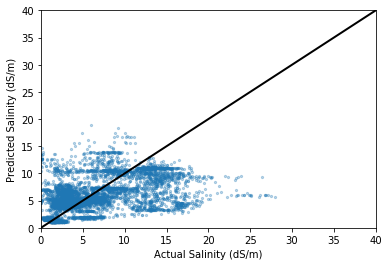

In [43]:
plot_actual_vs_predicted(y, y_hat)

field_dict = { 1:'#B30000',  2:'#FF3333',  3:'#FF9999',  4:'#FF8533',  5:'#FFB366',
              6:'#FFFF1A',  7:'#ACE600',  8:'#739900',  9:'#006622', 10:'#00CC66',
             11:'#00E6B8', 12:'#66C2FF', 13:'#0039E6', 14:'#9999FF', 15:'#FF99FF',
             16:'#CC00CC', 17:'#7A00CC', 18:'#BF8040', 19:'#663300', 20:'#000000',
             21:'#737373', 22:'#D9D9D9'}

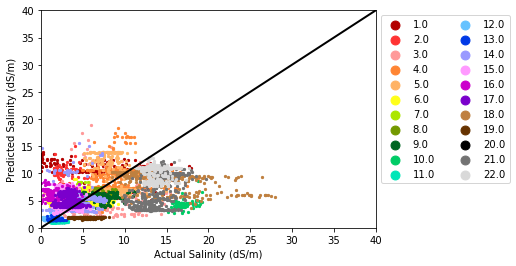

In [44]:
field_list = df_small_outlier_removed['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list)

### On singlebands only?

In [46]:
# Define X and y
y = df_singlebands_or['salinity'].values
drop_columns = [0, 1]
X = df_singlebands_or.drop(df_singlebands_or.columns[drop_columns], axis=1).values

In [51]:
# model
model = RandomForestRegressor
parameter_grid = {'n_estimators': [100], 'min_samples_leaf': [1, 2, 10, 20, 30],
                 'max_features': [2, 7, 12]}
kwarg_list = [dict(zip(parameter_grid, v)) for v in product(*parameter_grid.values())]

In [52]:
kwarg_list

[{'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 12, 'min_samples_leaf': 2, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 12, 'min_samples_leaf': 10, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 20, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 20, 'n_estimators': 100},
 {'max_features': 12, 'min_samples_leaf': 20, 'n_estimators': 100},
 {'max_features': 2, 'min_samples_leaf': 30, 'n_estimators': 100},
 {'max_features': 7, 'min_samples_leaf': 30, 'n_estimators': 100},
 {'max_features': 12, 'min_samples_leaf': 30, 'n_estimators': 10

In [53]:
%%time
mse_list = []
predicted_list = []

for index, kwargs in enumerate(kwarg_list):
    print("Working on:\t" + str(kwargs))
    y_hat, mse = cross_validate_lofo_sklearn(df_singlebands_or, drop_columns, model,normalize = True, **kwargs) 
    predicted_list.append(y_hat)
    mse_list.append(mse)
    print("\t\tMSE: " + str(mse))

Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 2}
		MSE: 20.66189347007375
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 7}
		MSE: 23.91849838289696
Working on:	{'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 12}
		MSE: 27.70009144375173
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 2}
		MSE: 20.880078384089895
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 7}
		MSE: 23.614101959799445
Working on:	{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 12}
		MSE: 25.78918825039803
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 2}
		MSE: 22.16202339911479
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 7}
		MSE: 22.933969490872588
Working on:	{'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 12}
		MSE: 22.31502479337897
Working on:	{'n_estimators': 100, 'min_samples_leaf': 20, 'max_features': 2}
		MSE

In [54]:
best_run_index = np.argmin(mse_list)
params = kwarg_list[best_run_index]
y_hat = predicted_list[best_run_index]
mse = mse_list[best_run_index]

In [55]:
print('best run index:', best_run_index)
print('MAE: %.2f' % mean_absolute_error(y, y_hat))
print('MSE: %.2f' % mean_squared_error(y, y_hat))
print('R_squared: %.2f' % r2_score(y, y_hat))

best run index: 14
MAE: 3.27
MSE: 19.69
R_squared: 0.22


In [56]:
kwarg_list[best_run_index]

{'max_features': 12, 'min_samples_leaf': 30, 'n_estimators': 100}

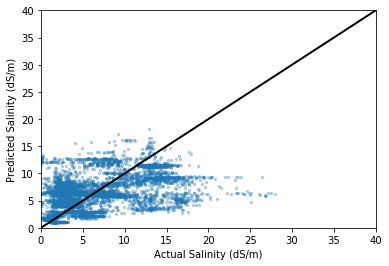

In [57]:
plot_actual_vs_predicted(y, y_hat)

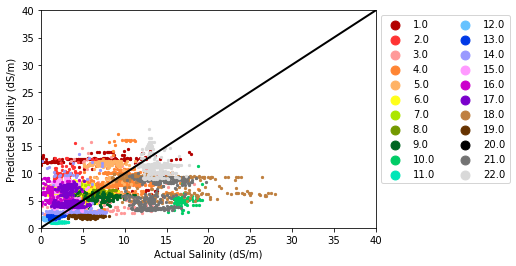

In [58]:
field_list = df_singlebands_or['Field_ID'].values
plot_actual_vs_predicted_fields(y, y_hat, field_list)

#### eh, that wasn't useful, and didn't perform any better. move along. 
#### RF isn't the best idea bc of the range issues anyways.